# Homework_4 - California Housing

Created on Sat Sep 14 23:16:39 2024
@author: hanna.dunska

## Step 0. Setting up the libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from scipy.stats import zscore

## Step 1. Data Loading

In [2]:
california_housing = fetch_california_housing(as_frame=True)

data = california_housing['frame']
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


# Step 2. Defining the Target Data

In [3]:
target = data.pop('MedHouseVal')
target.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

# Step 3. Data Overview

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


# Step 4. Features Distributiuon

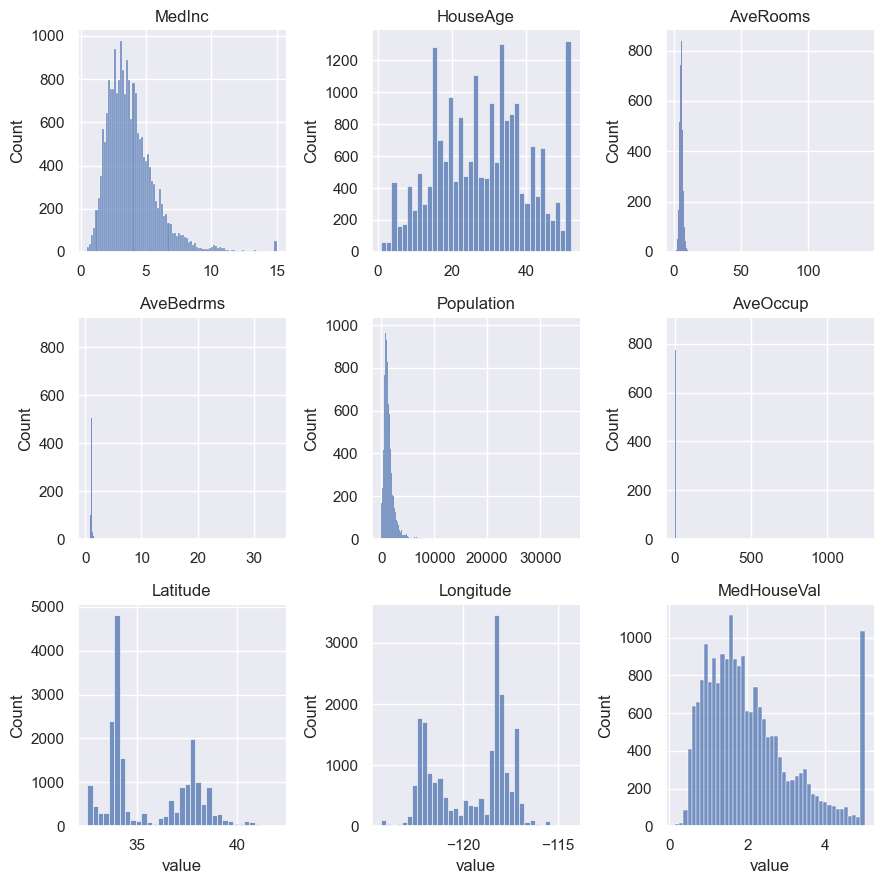

In [5]:
sns.set_theme()

melted = pd.concat([data, target], axis=1).melt()

g = sns.FacetGrid(melted,
                  col='variable',
                  col_wrap=3,
                  sharex=False,
                  sharey=False)

g.map(sns.histplot, 'value')

g.set_titles(col_template='{col_name}')

g.tight_layout()

# Step 5. Possible Outliers Overview

In [6]:
features_of_interest = ['AveRooms', 'AveBedrms', 'AveOccup', 'Population']
data[features_of_interest].describe()

,AveRooms,AveBedrms,AveOccup,Population
count,20640.000000,20640.000000,20640.000000,20640.000000
mean,5.429000,1.096675,3.070655,1425.476744
std,2.474173,0.473911,10.386050,1132.462122
min,0.846154,0.333333,0.692308,3.000000
25%,4.440716,1.006079,2.429741,787.000000
50%,5.229129,1.048780,2.818116,1166.000000
75%,6.052381,1.099526,3.282261,1725.000000
max,141.909091,34.066667,1243.333333,35682.000000


# Step 6. Outliers Defining

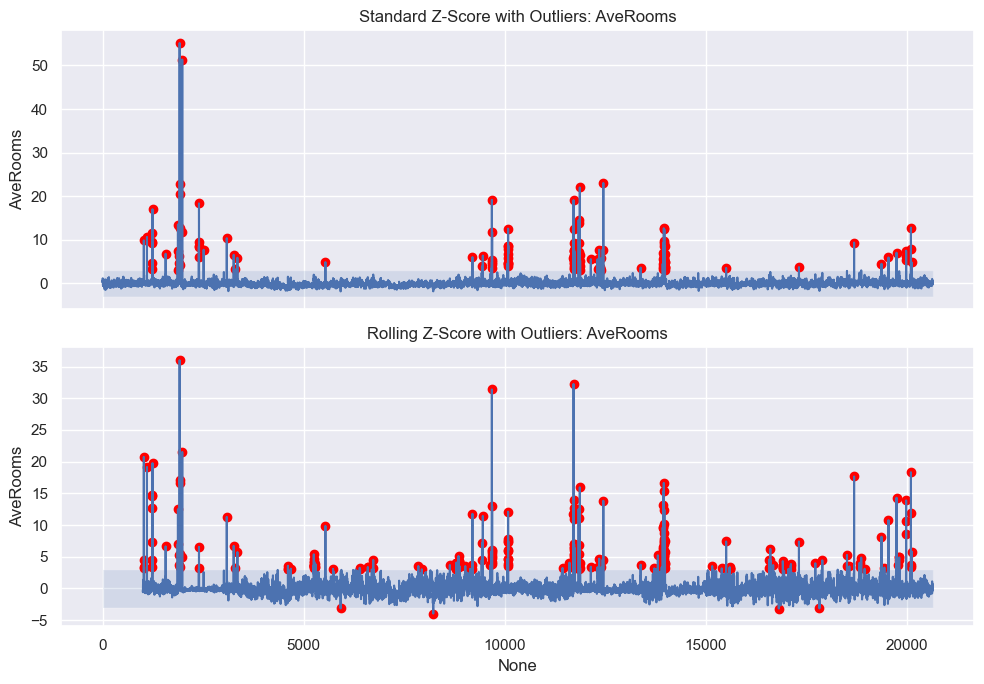

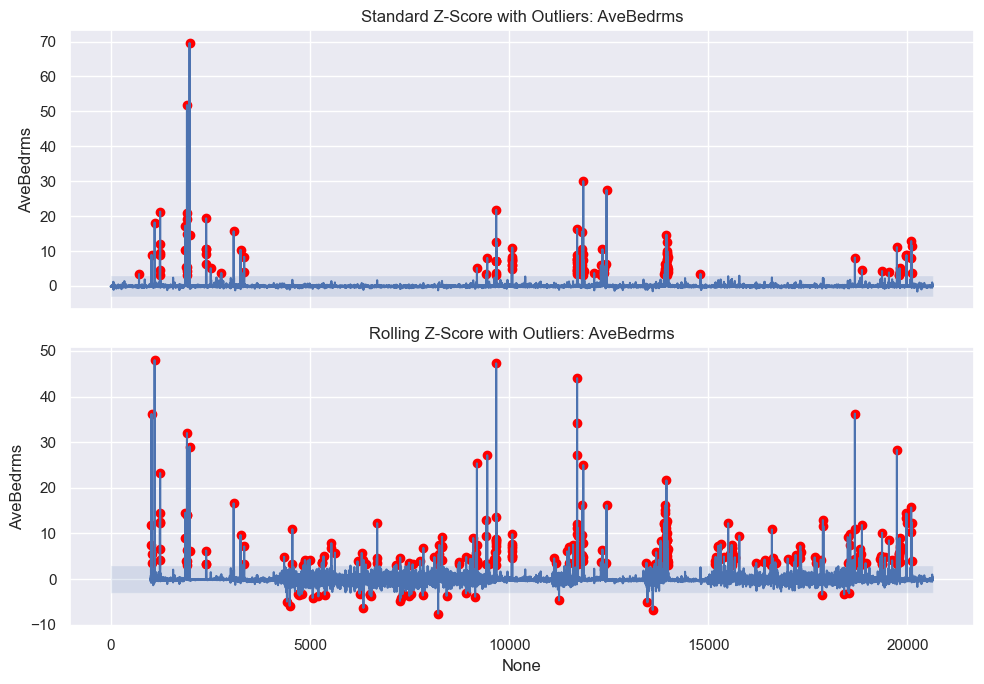

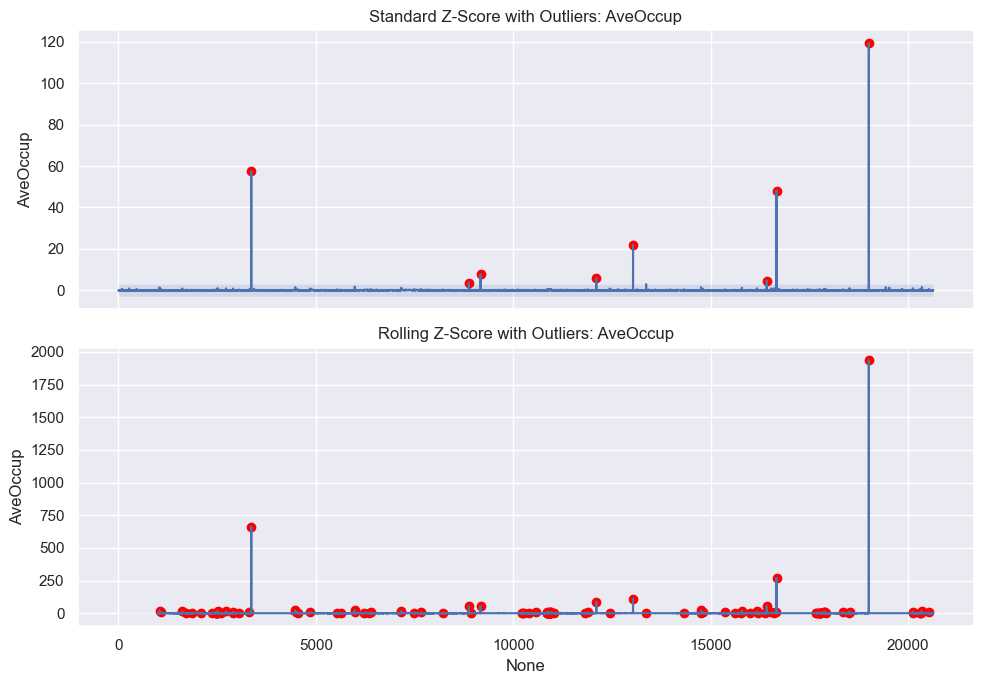

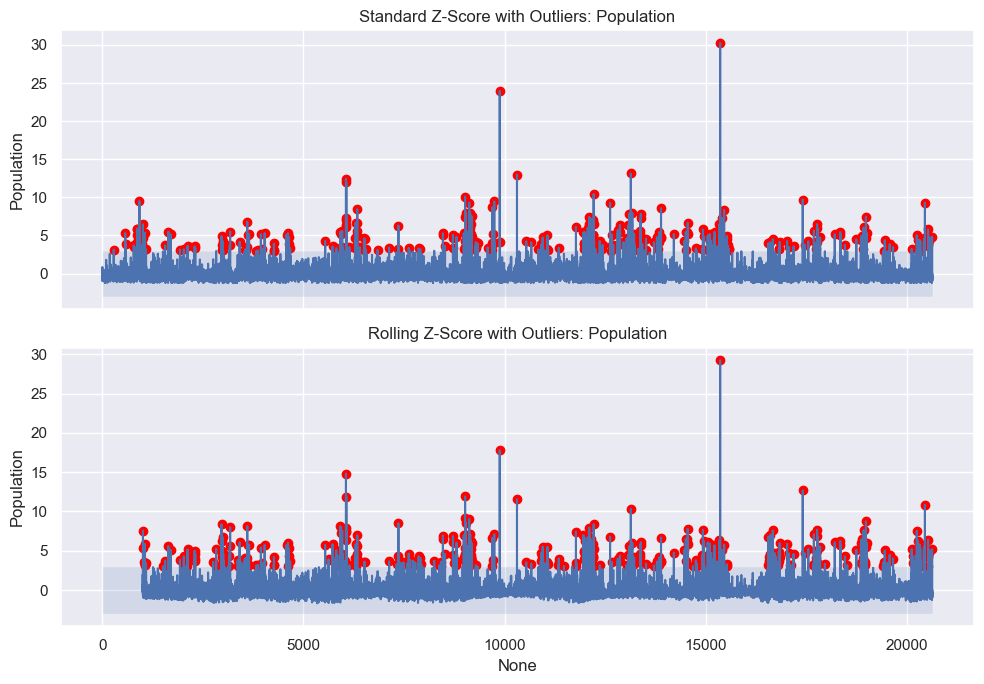

In [7]:
# Defining rolling z-score function
def zscore_adv(x, window):
    r = x.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (x - m) / s
    return z

# Function for processing and plotting the results of Standard and Rolling ZScore
def process_column(data_column, column_name, window=1000, threshold=3, plot=True):
    # NaN Check
    data_cleaned = data_column.dropna()

    # Calculating standard and rolling z-scores
    df_zscore = zscore(data_cleaned, nan_policy='omit')
    df_zscore_adv = zscore_adv(data_cleaned, window=window)

    # Identifying and marking outliers
    outliers_standard = np.where((df_zscore < -threshold) | (df_zscore > threshold))[0]
    outliers_rolling = np.where((df_zscore_adv < -threshold) | (df_zscore_adv > threshold))[0]

    if plot:
        # Plotting
        fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 7))

        # Standard z-score plot with outliers marked
        sns.lineplot(x=data_cleaned.index, y=df_zscore, ax=axes[0])
        axes[0].fill_between(range(len(df_zscore)), -threshold, threshold, alpha=0.15)
        axes[0].scatter(data_cleaned.index[outliers_standard], df_zscore[outliers_standard], color='red')
        axes[0].set_title(f"Standard Z-Score with Outliers: {column_name}")

        # Rolling z-score plot with outliers marked
        sns.lineplot(x=data_cleaned.index, y=df_zscore_adv, ax=axes[1])
        axes[1].fill_between(range(len(df_zscore_adv)), -threshold, threshold, alpha=0.15)
        axes[1].scatter(data_cleaned.index[outliers_rolling], df_zscore_adv[outliers_rolling], color='red')
        axes[1].set_title(f"Rolling Z-Score with Outliers: {column_name}")

        plt.tight_layout()
        plt.show()

    # Return the outliers
    return outliers_standard, outliers_rolling

# Creating a new DataFrame
cleaned_data = data.copy()

# Displaying both standard and rolling outliers for review
for column in features_of_interest:
    process_column(data[column], column, window=1000, threshold=3)

# Step 7. Outliers Cleaning

In [8]:
# Choosing the method after reviewing the plots
chosen_methods = {
    'AveRooms': 'rolling', 
    'AveBedrms': 'rolling',
    'AveOccup': 'rolling',
    'Population': 'rolling'
}

# Applying the chosen method to clean the data and performing interpolation
for column, method in chosen_methods.items():
    if method == 'standard':
        outliers_standard, _ = process_column(data[column], column, window=1000, threshold=3, plot=False)
        cleaned_data.loc[outliers_standard, column] = np.nan  # Remove standard outliers
    elif method == 'rolling':
        _, outliers_rolling = process_column(data[column], column, window=1000, threshold=3, plot=False) 
        cleaned_data.loc[outliers_rolling, column] = np.nan  # Remove rolling outliers
    
    # Perform interpolation after removing outliers
    cleaned_data[column] = cleaned_data[column].interpolate()

# Displaying the cleaned data
cleaned_data[features_of_interest].describe()

,AveRooms,AveBedrms,AveOccup,Population
count,20640.000000,20640.000000,20640.000000,20640.000000
mean,5.312840,1.070999,2.907694,1337.207534
std,1.324493,0.151054,0.749142,821.546308
min,1.000000,0.333333,0.692308,3.000000
25%,4.440247,1.006190,2.428945,784.000000
50%,5.226838,1.048632,2.816355,1159.000000
75%,6.042629,1.098563,3.275749,1694.000000
max,26.452174,5.397260,18.444444,12203.000000


# Step 8. Latitude and longitude as Factors

Text(0.5, 1.0, 'Median house value depending of\n their spatial location')

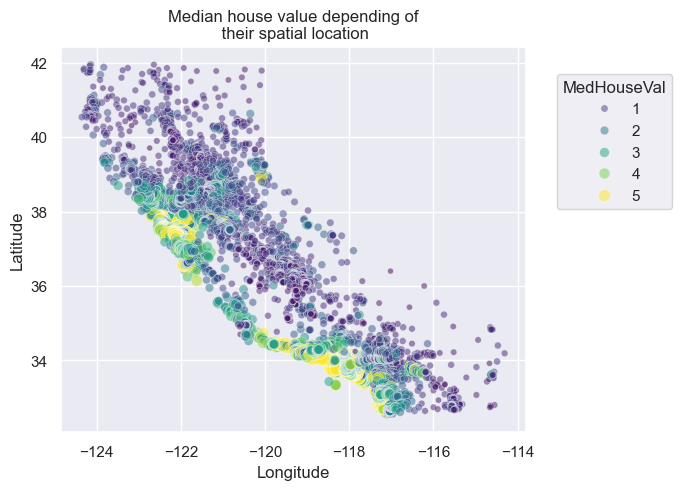

In [9]:
fig, ax = plt.subplots(figsize=(6, 5))

sns.scatterplot(
    data=data,
    x='Longitude',
    y='Latitude',
    size=target,
    hue=target,
    palette='viridis',
    alpha=0.5,
    ax=ax)

plt.legend(
    title='MedHouseVal',
    bbox_to_anchor=(1.05, 0.95),
    loc='upper left')

plt.title('Median house value depending of\n their spatial location')

# Step 9. Correlation Matrix

<Axes: >

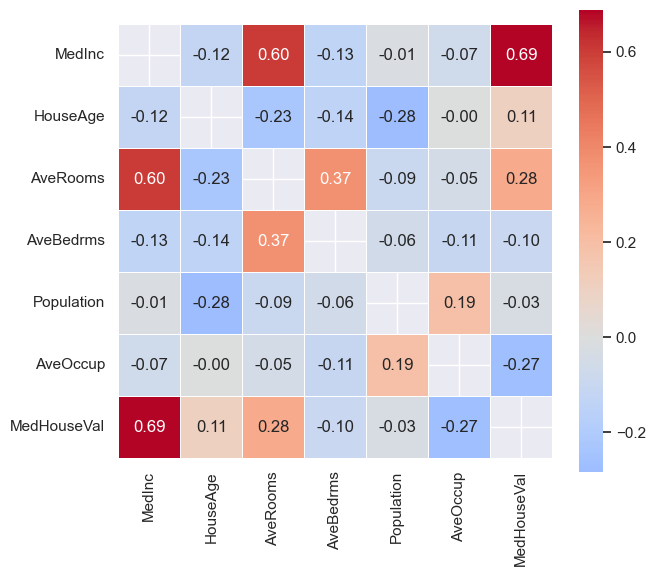

In [10]:
columns_drop = ['Longitude', 'Latitude']
subset = pd.concat([cleaned_data, target], axis=1).drop(columns=columns_drop)

corr_mtx = subset.corr()

mask_mtx = np.zeros_like(corr_mtx)
np.fill_diagonal(mask_mtx, 1)

fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(subset.corr(),
            cmap='coolwarm',
            center=0,
            annot=True,
            fmt='.2f',
            linewidth=0.5,
            square=True,
            mask=mask_mtx,
            ax=ax)

# Step 10. Dropping the High-Correlated Features

In [11]:
columns_drop = ['AveRooms']
shortened_data = cleaned_data.drop(columns=columns_drop)

# Check the shortened data
shortened_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveBedrms   20640 non-null  float64
 3   Population  20640 non-null  float64
 4   AveOccup    20640 non-null  float64
 5   Latitude    20640 non-null  float64
 6   Longitude   20640 non-null  float64
dtypes: float64(7)
memory usage: 1.1 MB


# Step 11. Data Split to the test and train 

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    shortened_data,
    target,
    test_size=0.2,
    random_state=42)

# Step 12. Data Standartization

In [13]:
scaler = StandardScaler().set_output(transform='pandas').fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.describe()

,MedInc,HouseAge,AveBedrms,Population,AveOccup,Latitude,Longitude
count,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04
mean,-6.519333e-17,-9.251859e-18,-1.623378e-15,-1.071494e-16,5.147691e-17,6.400995e-17,1.753335e-15
std,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00
min,-1.775438e+00,-2.190766e+00,-4.795359e+00,-1.621996e+00,-2.942172e+00,-1.447697e+00,-2.377207e+00
25%,-6.900689e-01,-8.417859e-01,-4.231663e-01,-6.712365e-01,-6.350084e-01,-8.018107e-01,-1.110749e+00
50%,-1.758995e-01,3.108328e-02,-1.474406e-01,-2.158920e-01,-1.222879e-01,-6.473597e-01,5.346501e-01
75%,4.686502e-01,6.658972e-01,1.798254e-01,4.337329e-01,4.890204e-01,9.720351e-01,7.839530e-01
max,5.839268e+00,1.856173e+00,2.809107e+01,1.319188e+01,2.064980e+01,2.951816e+00,2.628794e+00


# Step 13. Building the Linear Regression model

In [14]:
model = LinearRegression().fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
ymin, ymax = y_train.agg(['min', 'max']).values
y_pred = pd.Series(y_pred, index=X_test_scaled.index).clip(ymin, ymax)

r_sq = model.score(X_train_scaled, y_train)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'R2: {r_sq:.2f} | MAE: {mae:.2f} | MAPE: {mape:.2f}')

R2: 0.65 | MAE: 0.49 | MAPE: 0.30


# Step 14. Building the Polimomial model

In [15]:
# [a, b] -> [1, a, b, a^2, ab, b^2]
poly = PolynomialFeatures(2).set_output(transform='pandas')

Xtr = poly.fit_transform(X_train_scaled)
Xts = poly.transform(X_test_scaled)

model_upd = LinearRegression().fit(Xtr, y_train)
y_pred_upd = model_upd.predict(Xts)
y_pred_upd = pd.Series(y_pred_upd, index=Xts.index).clip(ymin, ymax)

r_sq_upd = model_upd.score(Xtr, y_train)
mae_upd = mean_absolute_error(y_test, y_pred_upd)
mape_upd = mean_absolute_percentage_error(y_test, y_pred_upd)

print(f'R2: {r_sq_upd:.2f} | MAE: {mae_upd:.2f} | MAPE: {mape_upd:.2f}')

R2: 0.70 | MAE: 0.45 | MAPE: 0.26


# Step 15. Conclusion

### Comparison of the obtained metrics with the model metrics in the section "Application of Linear Regression. Model Accuracy Evaluation" of the topic "Linear Regression."

Compared to the model from the study guide, I made the following important steps:

1. I cleaned ['AveRooms', 'AveBedrms', 'AveOccup', 'Population'] of outliers using the advanced ZScore method — Rolling ZScore - for defining them. For anomaly removal, I applied a method of removing outliers by imputing values using the interpolate() function. I chose the Rolling ZScore over the standard ZScore based on experimental results.
2. I removed the feature 'AveRooms' because it has a high correlation with MedInc but correlates worse with the target variable MedHouseVal compared to MedInc.

Outliers and highly correlated features degrade the predictive ability of my model, so this processing allowed me to improve the results.

 - In the linear regression model, instead of R2: 0.61 | MAE: 0.52 | MAPE: 0.31, I obtained R2: 0.65 | MAE: 0.49 | MAPE: 0.30.
 - In the polynomial regression model, instead of R2: 0.69 | MAE: 0.46 | MAPE: 0.27, I obtained R2: 0.70 | MAE: 0.45 | MAPE: 0.26.

As we can see, I managed to slightly reduce the model’s errors—both MAE and MAPE decreased—and somewhat improve the model’s ability to explain the data, as indicated by the increase in R².